# Lesson 2

## 0. Introduction

The main objective of this lesson is to modify the vgg16 network in such way, that it will outperform my previous network in kaggle dogs&cats competition - score should be lower than 0.07829.

### 0.1 Plan

The plan to achieve this goal is as follows:

1. Create data structure necessary for the experiment
2. Create a vgg16 network finetuned to the cats&dogs using methods from Lesson 1
3. Prepare a setup to check if the results make sense
4. Modify the vgg16 network manually, using only keras methods
5. Finetune last layer
6. Retrain the previous layers
7. Iterate until the results are satisfactory
8. Submit to Kaggle


### 0.2 Initial imports

In [1]:
%matplotlib inline
from __future__ import division,print_function

import os, json 
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots
import vgg16; reload(vgg16)
from vgg16 import Vgg16

Using TensorFlow backend.
/Users/michalstechly/Documents/Fast_AI/fast-venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Data structure setup (optional)

This code is copied from the Lesson 1 notebook.
You can omit it if you have all the necessary data.

In [2]:
path = os.path.join("..","data", "dogscats")

To download the data follow the instructions: http://wiki.fast.ai/index.php/Kaggle_CLI and put the data to the dogscats_data directory.

#### Imports + helper function:

In [ ]:
import glob
import shutil
def safe_mkdir(path):
    """
    Checks if a directory exists. If not, creates it.
    """
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        pass
    except AttributeError as exc:
        pass

#### Creating training and validation set.

Also, puts test data into a structure where we can use get_batches method easily.

In [ ]:
os.rename(os.path.join(path, "train"), os.path.join(path, "train_original"))

In [ ]:
cats_train_path = os.path.join(path, "train", "cats")
cats_valid_path = os.path.join(path, "validation", "cats")
safe_mkdir(cats_train_path)
safe_mkdir(cats_valid_path)


dogs_train_path = os.path.join(path, "train", "dogs")
dogs_valid_path = os.path.join(path, "validation", "dogs")
safe_mkdir(dogs_train_path)
safe_mkdir(dogs_valid_path)

filenames = glob.glob(os.path.join(path, "train_original", "*"))

cats_counter = 0
dogs_counter = 0

for filename in filenames:
    name = filename.split("/")[-1]
    if "cat" in name:
        if cats_counter < 3:
            shutil.copy(filename, os.path.join(cats_train_path, name))
            cats_counter += 1
        else:
            shutil.copy(filename, os.path.join(cats_valid_path, name))
            cats_counter = 0
    if "dog" in name:
        if dogs_counter < 3:
            shutil.copy(filename, os.path.join(dogs_train_path, name))
            dogs_counter += 1
        else:
            shutil.copy(filename, os.path.join(dogs_valid_path, name))
            dogs_counter = 0

#### Creating sample set.

Since the training data is already in the correct structure, we just need to extract the validation set from it.
Also, puts test data into a structure where we can use get_batches method easily.

In [ ]:
sample_path = os.path.join(path, "sample")
class_names = ['dogs', 'cats']

for class_name in class_names:
    for set_name in ["train", "validation"]:
        file_paths = glob.glob(os.path.join(path, set_name, class_name, "*"))
        safe_mkdir(os.path.join(sample_path, set_name, class_name))
        for file_path in file_paths[:12]:
            filename = file_path.split("/")[-1]
            shutil.copy(file_path, os.path.join(sample_path, set_name, class_name, filename))

file_paths = glob.glob(os.path.join(path, "test", "*"))
safe_mkdir(os.path.join(sample_path, "test"))
for file_path in file_paths[:12]:
    filename = file_path.split("/")[-1]
    shutil.copy(file_path, os.path.join(sample_path, "test", filename))

## 2. Lesson 1 network

In [3]:
# path = os.path.join("..", "dogscats_data")
path = os.path.join("..","data", "dogscats", "sample")

In [4]:
batch_size = 64
network = Vgg16()

train_batches = network.get_batches(os.path.join(path, "train"), batch_size=batch_size)
validation_batches = network.get_batches(os.path.join(path, "validation"),batch_size=batch_size)
network.finetune(train_batches)

Found 24 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [5]:
number_of_epochs = 1
model_name = "model_1"

In [6]:
for i in range(number_of_epochs):
    network.fit(train_batches, validation_batches)
    network.model.save_weights(model_name + "_" + str(i) + ".h5")

Epoch 1/1
24/24 [==============================] - 138s - loss: 2.5621 - acc: 0.4167 - val_loss: 0.8568 - val_acc: 0.5833


(Optional) Load the existing model

In [ ]:
network.model.load_weights("model_1_2.h5")

## 3. Validating network

### 3.1 Create predictions

In [90]:
validation_batches, probabilities = network.test(os.path.join(path, "validation"), batch_size = batch_size)

Found 24 images belonging to 2 classes.


In [91]:
filenames = validation_batches.filenames
expected_labels = validation_batches.classes #0 or 1
#Round our predictions to 0/1 to generate labels
predictions = probabilities[:,0]
predicted_labels = np.round(1-predictions)
correct_cases = predicted_labels == expected_labels


In [20]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(os.path.join(path, "validation", filenames[i])) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4


### 3.2 Few random correct labels

In [21]:
import random
correct_ids = np.where(predicted_labels == expected_labels)[0]
random_correct_ids = random.sample(correct_ids, n_view)

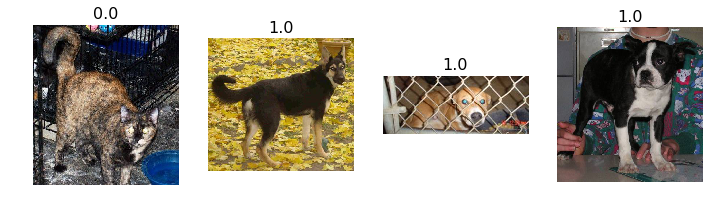

In [24]:
plots_idx(random_correct_ids, titles=)

### 3.3 Few random incorrect labels

In [75]:
import random
incorrect_ids = np.where(predicted_labels != expected_labels)[0]
random_incorrect_ids = random.sample(incorrect_ids, n_view)

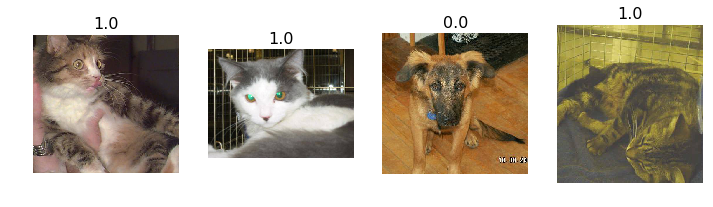

In [76]:
plots_idx(random_incorrect_ids, titles=predicted_labels[random_incorrect_ids])

### 3.4a Most correct cats

In [96]:
incorrect_cats = np.where((predicted_labels==0) & (predicted_labels!=expected_labels))[0]
correct_cats_probabilities = np.copy(probabilities[:,0])
correct_cats_probabilities[incorrect_cats] = 0
most_certain_correct_cats = correct_cats_probabilities.argsort()[-n_view:][::-1]

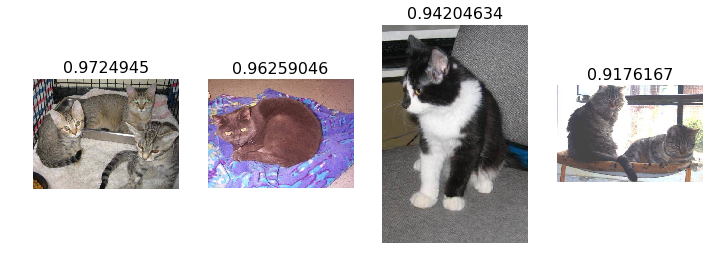

In [97]:
plots_idx(most_certain_correct_cats, titles=probabilities[:,0][most_certain_correct_cats])

### 3.4b Most correct dogs

In [98]:
incorrect_dogs = np.where((predicted_labels==1) & (predicted_labels!=expected_labels))[0]
correct_dogs_probabilities = np.copy(probabilities[:,1])
correct_dogs_probabilities[incorrect_dogs] = 0
most_certain_correct_dogs = correct_dogs_probabilities.argsort()[-n_view:][::-1]

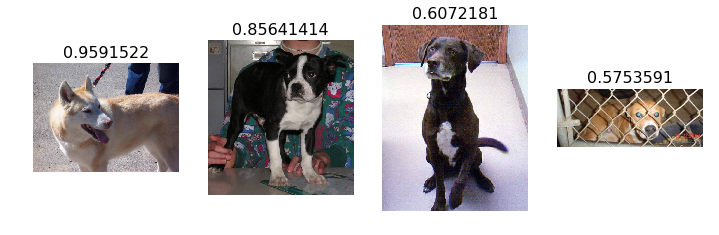

In [99]:
plots_idx(most_certain_correct_dogs, titles=probabilities[:,1][most_certain_correct_dogs])

### 3.5a Least correct cats

In [100]:
correct_cats = np.where((predicted_labels==0) & (predicted_labels==expected_labels))[0]
incorrect_cats_probabilities = np.copy(probabilities[:,0])
incorrect_cats_probabilities[correct_cats] = 0
most_certain_incorrect_cats = incorrect_cats_probabilities.argsort()[-n_view:][::-1]

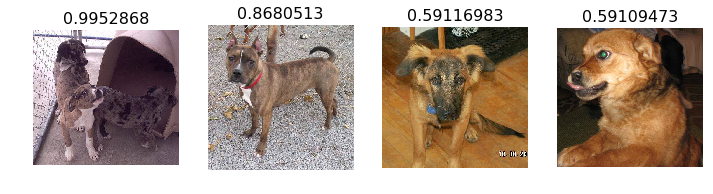

In [101]:
plots_idx(most_certain_incorrect_cats, titles=probabilities[:,0][most_certain_incorrect_cats])

### 3.5b Least correct dogs

In [102]:
correct_dogs = np.where((predicted_labels==1) & (predicted_labels==expected_labels))[0]
incorrect_dogs_probabilities = np.copy(probabilities[:,1])
incorrect_dogs_probabilities[correct_dogs] = 0
most_certain_incorrect_dogs = incorrect_dogs_probabilities.argsort()[-n_view:][::-1]

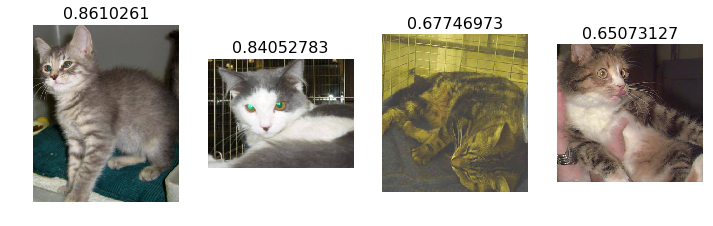

In [104]:
plots_idx(most_certain_incorrect_dogs, titles=probabilities[:,1][most_certain_incorrect_dogs])

### 3.6 Most uncertain cases

In [124]:
cats_probabilities = np.copy(probabilities[:,0])
most_uncertain = np.abs(cats_probabilities-0.5).argsort()[:n_view][::-1]

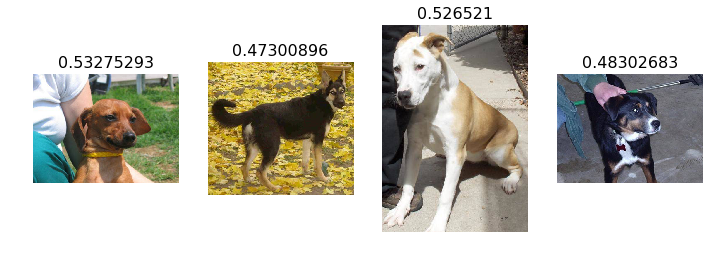

In [125]:
plots_idx(most_uncertain, titles=probabilities[:,0][most_uncertain])